In [1]:
import theano
import theano.tensor as T
import theano.tensor.nnet as nnet
import numpy as np
import time

import cv2 
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal
import time
from math import sqrt
from skimage import transform
import skimage 

In [2]:
def prepImg(fileName, scale):
    img = cv2.imread(fileName, 0)
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(img,-1,kernel)
    img_rescaled = get_rescaled(dst, scale)    
    return img_rescaled

def get_rescaled(img, percent):
    width, height = img.shape
    resized = skimage.transform.resize(img, output_shape=[int(width * percent), 
                int(height * percent)], order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    return resized

In [3]:
combine = cv2.imread("./training/preprocess/img0_combined.jpg", 0)

In [4]:
combine1 = combine / 255

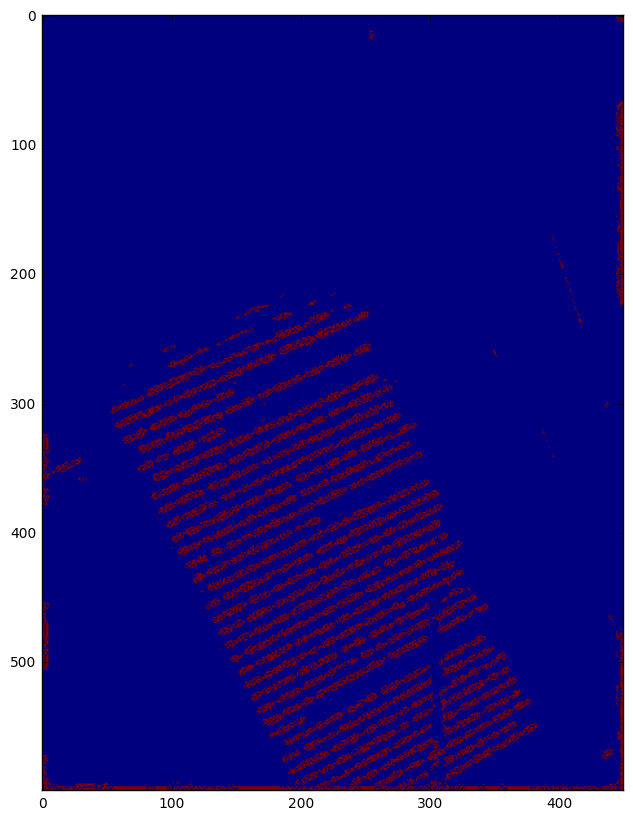

In [5]:
plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(combine1)    


[[ 0.00084073  0.00301024  0.00647097  0.00835139  0.00647097  0.00301024
   0.00084073]
 [ 0.00301024  0.01077825  0.02316949  0.02990239  0.02316949  0.01077825
   0.00301024]
 [ 0.00647097  0.02316949  0.04980635  0.06427974  0.04980635  0.02316949
   0.00647097]
 [ 0.00835139  0.02990239  0.06427974  0.082959    0.06427974  0.02990239
   0.00835139]
 [ 0.00647097  0.02316949  0.04980635  0.06427974  0.04980635  0.02316949
   0.00647097]
 [ 0.00301024  0.01077825  0.02316949  0.02990239  0.02316949  0.01077825
   0.00301024]
 [ 0.00084073  0.00301024  0.00647097  0.00835139  0.00647097  0.00301024
   0.00084073]]


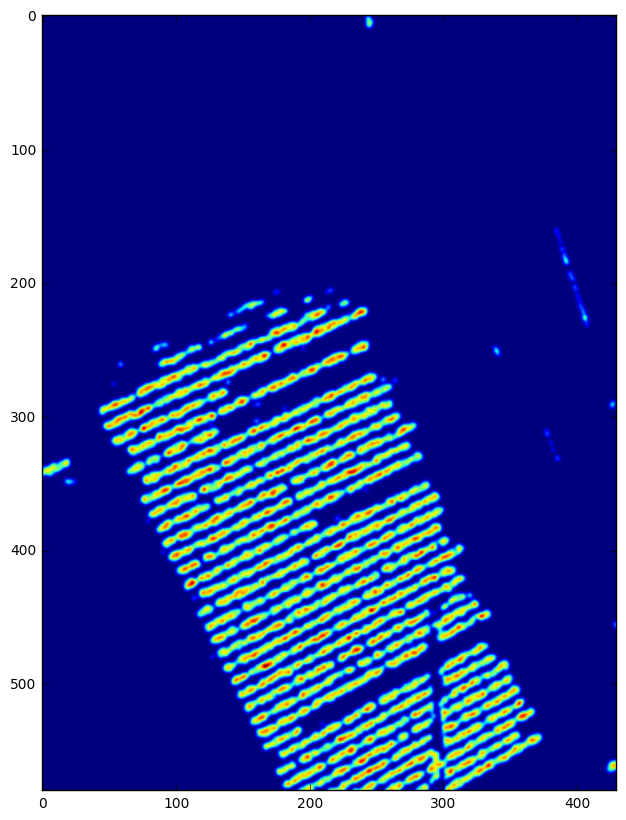

In [7]:
ksize = 7
kernel = cv2.getGaussianKernel(ksize, 0.3*((ksize-1)*0.5 - 1) + 0.8)
gaussk = signal.convolve2d(kernel, np.transpose(kernel))
print gaussk

# cutaway borders
border = 10


blurred = signal.convolve2d(combine1, gaussk, 'same')
cut = blurred[border:-border, border:-border]


plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(cut)    


# 
# print gausskernel
# blurred = cv2.GaussianBlur(combine1, 3, 2)
# # close to remove smaller regions that are not text
# kernel = np.ones((1,1),np.uint8)
# erosion = cv2.erode(combine1, kernel, 1)

# plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
# plt.imshow(erosion)    
# # open again to regain lost information

In [394]:
def findLines(maxAngl, minAngl, img):
    lines = cv2.HoughLines(img, rho = 0.9, theta = np.pi/360, threshold = 100)
    empty = np.ones((600, 450))
    output = np.ndarray([lines.size, 2])
    
    idx = 0
    for item in lines:
        for rho, theta in item:
            if theta < maxAngl and theta > minAngl:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))
                cv2.line(empty,(x1,y1),(x2,y2),(255,255,255),1)
                output[idx][0] = rho
                output[idx][1] = theta
#                 output.append([rho, theta])
            idx += 1
                
#     plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
#     plt.imshow(empty)  
    return lines
#     plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
#     plt.imshow(img)
    
    return output

maxAngl = np.pi/2 + np.pi/6
minAngl = np.pi/2 -np.pi/6

lines = findLines(maxAngl, minAngl, combine1)

In [410]:
lines = findLines(maxAngl, minAngl, combine1)

k = 10
L = lines.shape[0]
thetas = lines[:, 0, 1].reshape(L, 1)
means = np.ndarray([1, k])
thetasExt = np.tile(thetas, (1, k))

minAng = np.inf 
maxAng = -np.inf
for i in range(L):
    if (lines[i][0][1] < minAng):
        minAng = thetas[i]
    if (lines[i][0][1] > maxAng):
        maxAng = thetas[i]
for i in range(k):
    means[0, i] = minAng + (maxAng - minAng) * i / (k - 1)

last = np.copy(means)
newMeans = np.ndarray([1, k])
# loop 

for p in range(1000):   
    
    if p%2 == 0:
        secLast = np.copy(newMeans)        
        means = np.copy(last)
    else:        
        last = np.copy(newMeans)
        means = np.copy(secLast)
    
    meansExt = np.tile(means, (L, 1))
    difference = np.abs(thetasExt - meansExt)
    minVals = np.min(difference, 1).reshape(L, 1)
    minValsExt = np.tile(minVals, (1, k))
    positions = np.argwhere(difference - minValsExt == 0)[:, 1]

    result = np.empty([k], dtype=list)
    rhos = np.empty([k], dtype=list)
    for i in range(k):
        result[i] = []
        rhos[i] = []
    for i in range(L):
        result[positions[i]].append(thetasExt[i, 0])
        rhos[positions[i]].append(lines[i, 0 ])

    # calculate new mean
    newMeans = np.ndarray([1, k])
    for i in range(k):
        if len(result[i]) == 0:
            newMeans[0, i] = sum(result[i])
        else:
            newMeans[0, i] = sum(result[i])/len(result[i])

    if (newMeans == last).all() or (newMeans == secLast).all():
        print "found it at " + str(p) + "th itteration"
        break
    
# for i in range(k):
#     print len(result[i])

largestCluster = 0
for i in range(k):
    if len(result[i]) > largestCluster:
        largestCluster = len(result[i])
        idx = i        
        
useThis = result[idx]
useRhos = rhos[idx]


medianTheta = sum(result[idx])/largestCluster
medianRho = sum(rhos[idx])/largestCluster

print medianTheta
print medianRho
    

found it at 41th itteration
2.42637986481
-6.34052121131


In [390]:
# for i in range(k):
#     print len(result[i])
    


lines = findLines(maxAngl, minAngl, combine1)

k = 4
L = lines.shape[0]
thetas = lines[:, 0, 1]
print thetas.shape
means = np.ndarray([k, 1])
thetasExt = np.tile(thetas, (k, 1))
test = np.tile(thetas, (k, 1))

minAng = np.inf 
maxAng = -np.inf
for i in range(L):
    if (lines[i][0][1] < minAng):
        minAng = thetas[i]
    if (lines[i][0][1] > maxAng):
        maxAng = thetas[i]
for i in range(k):
    means[i] = minAng + (maxAng - minAng) * i / (k - 1)

meansExt = np.tile(means, (1, L))
idxsExt = np.tile(idxs, (L, 1))
difference = np.abs(thetasExt - meansExt)
difference = np.transpose(difference)
minVals = np.min(difference, 1)
minValsExt = np.tile(minVals, (4, 1))
minValsExt = np.transpose(minValsExt)
positions = np.argwhere(difference - minValsExt == 0)[:, 1]

result = np.empty([4], dtype=list)
for i in range(k):
    result[i] = []
for i in range(L):
    result[positions[i]].append(thetasExt[0, i])

# calculate new mean
for i in range(k):
    means[i] = sum(result[i])/len(result[i])


(388,)


In [391]:
k = 4

clusters = np.ndarray(2,4)
means = np.ndarray([k,1])
means[0] = 0
means[1] = 1
means[2]





TypeError: data type not understood

In [151]:
print len(lines)
print lines[0][0]

def calcCrossing(line1, line2):
    # equation for line from rho and theta
#     theta1 = line1[0]
#     rho1 = 
#     x = cos(theta)
#     y = sin(theta)
#     x1, y1 = 
    
    return [x, y]

# calculate k value
for idx in range(len(lines)):
    rho = lines[idx][0]
    theta = lines[idx][1]
    k = np.pi/2 - theta 
    k = np.sin(theta)/np.cos(theta)
    print theta
#     k = cos()

crossings = []
for idx in range(len(lines)):
    for idx2 in range(idx, len(lines)):
        line1 = lines[idx1]
        line2 = lines[idx2]
        crossings.append(calcCrossing(line1, line2))
        

69
598.95
1.5708
1.57952
1.16064
1.14319
1.10828
1.13446
1.58825
1.16064
1.10828
1.13446
1.15192
1.14319
1.10828
1.12574
1.13446
1.16937
1.10828
1.09083
1.09083
1.10828
1.12574
1.09956
1.12574
1.12574
1.11701
1.11701
1.12574
1.59698
1.10828
1.5708
1.10828
1.10828
1.10828
1.13446
1.13446
1.09083
1.10828
1.13446
1.0821
1.09956
1.11701
1.09956
1.10828
1.11701
1.12574
1.09956
1.10828
1.15192
1.09956
1.5708
1.5708
1.5708
1.10828
1.10828
1.6057
1.09956
1.16064
1.0821
1.11701
1.12574
1.09956
1.11701
1.5708
1.5708
1.5708
2.03331
1.54462
1.61443
1.98968


NameError: name 'idx1' is not defined